In [ ]:
%pip install -U nbformat

In [2]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from statsmodels.tsa.seasonal import STL

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
custom_layout = go.Layout(
    paper_bgcolor='white',        
    plot_bgcolor='rgba(250,250,250,0.8)',   
)

fig = go.Figure(layout=custom_layout)

template = go.layout.Template(layout=fig.layout)
pio.templates["my_template"] = template
pio.templates.default = "my_template"

import sys
sys.path.append("../utils")

from utils import load_csv

In [3]:
df = load_csv('../../data/features/fpt_features.csv')
df.head()

2025-05-26 16:32:31,753 - INFO - ✅ Load CSV thành công: ../../data/features/fpt_features.csv | shape = (4562, 11)


date   open   high    low  close  volume      EMA_9   SMA_5  SMA_10  \
0  2006-12-13  11.44  11.44  11.44  11.44   83530  13.681605  13.266  13.273   
1  2006-12-14  12.01  12.01  12.01  12.01  280710  13.867339  13.636  13.444   
2  2006-12-15  12.61  12.61  12.61  12.61  265300  14.007043  13.750  13.498   
3  2006-12-18  13.24  13.24  13.24  13.24  215790  14.092270  13.606  13.432   
4  2006-12-19  13.89  13.89  13.89  13.89  137520  14.114744  13.452  13.329   

      SMA_15     SMA_30  
0  13.235333  14.397667  
1  13.378000  14.550000  
2  13.471333  14.706333  
3  13.522667  14.870000  
4  13.540000  15.021667

In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

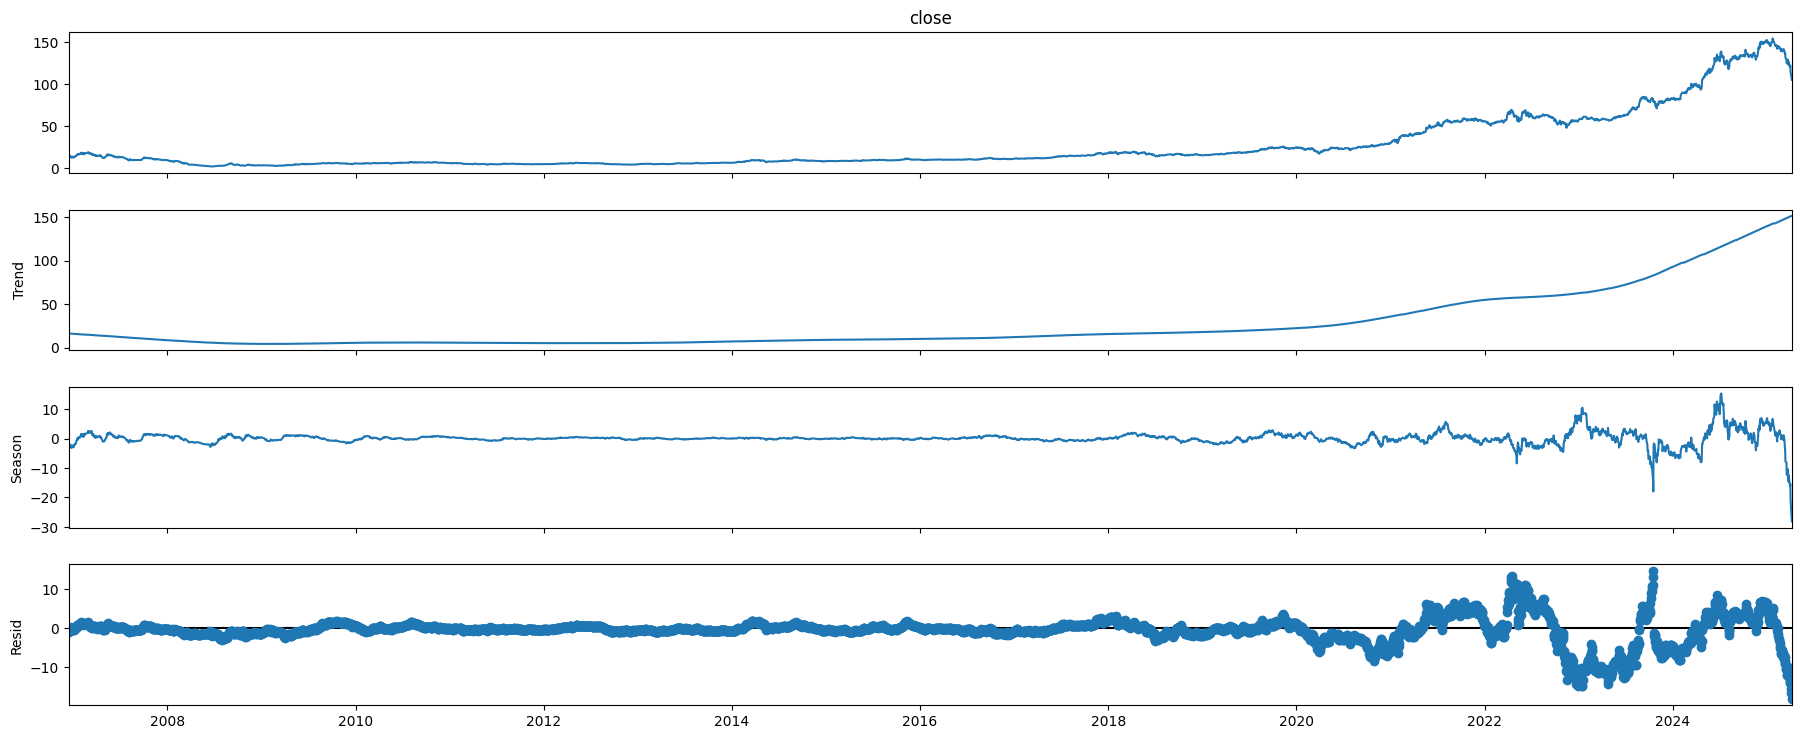

In [5]:
df_close = df[['date', 'close']].copy()
df_close['date'] = pd.to_datetime(df_close['date'])
df_close = df_close.set_index('date')

# Áp dụng STL decomposition
stl = STL(df_close['close'], period=365)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 8)

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.close, name='Close', opacity=0.2))
fig.show()

In [7]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.date, y=df.RSI, name='RSI'))
fig.show()


In [9]:
EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.close, name='close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [10]:
df['close'] = df['close'].shift(-1)

In [11]:
df = df.iloc[33:] 
df = df[:-1]      

df.index = range(len(df))

In [12]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.close,  name='Test'))
fig.show()  

In [14]:
drop_cols = ['date', 'volume', 'open', 'low', 'high']

train_df = train_df.drop(drop_cols, axis=1)
valid_df = valid_df.drop(drop_cols, axis=1)
test_df  = test_df.drop(drop_cols, axis=1)

In [16]:
y_train = train_df['close'].copy()
X_train = train_df.drop(['close'], axis=1)

y_valid = valid_df['close'].copy()
X_valid = valid_df.drop(['close'], axis=1)

y_test  = test_df['close'].copy()
X_test  = test_df.drop(['close'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3170 entries, 0 to 3169
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        3170 non-null   float64
 1   SMA_5        3170 non-null   float64
 2   SMA_10       3170 non-null   float64
 3   SMA_15       3170 non-null   float64
 4   SMA_30       3170 non-null   float64
 5   RSI          3170 non-null   float64
 6   MACD         3170 non-null   float64
 7   MACD_signal  3170 non-null   float64
dtypes: float64(8)
memory usage: 198.2 KB


In [19]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0)

clf = GridSearchCV(model, parameters, cv=5, scoring='neg_root_mean_squared_error')

# 👉 Huấn luyện GridSearchCV để tìm best params
clf.fit(X_train, y_train)

# 👉 Lấy mô hình tốt nhất và huấn luyện lại có theo dõi tập validation
best_model = clf.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)

# 👉 In kết quả
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


[0]	validation_0-rmse:34.01855
[1]	validation_0-rmse:33.44628
[2]	validation_0-rmse:32.90461
[3]	validation_0-rmse:32.39183
[4]	validation_0-rmse:31.90650
[5]	validation_0-rmse:31.43150
[6]	validation_0-rmse:30.98105
[7]	validation_0-rmse:30.55343
[8]	validation_0-rmse:30.13642
[9]	validation_0-rmse:29.75338
[10]	validation_0-rmse:29.37877
[11]	validation_0-rmse:29.03413
[12]	validation_0-rmse:28.70859
[13]	validation_0-rmse:28.38925
[14]	validation_0-rmse:28.09593
[15]	validation_0-rmse:27.80884
[16]	validation_0-rmse:27.54613
[17]	validation_0-rmse:27.28806
[18]	validation_0-rmse:27.06014
[19]	validation_0-rmse:26.83565
[20]	validation_0-rmse:26.62273
[21]	validation_0-rmse:26.41303
[22]	validation_0-rmse:26.22196
[23]	validation_0-rmse:26.03321
[24]	validation_0-rmse:25.86114
[25]	validation_0-rmse:25.69117
[26]	validation_0-rmse:25.53675
[27]	validation_0-rmse:25.38999
[28]	validation_0-rmse:25.24495
[29]	validation_0-rmse:25.11307
[30]	validation_0-rmse:24.98773
[31]	validation_0-